# An EDA of My Read books

## introduction<a name="introduction"></a>

This project is meant for me to practice writing SQL queries, creating data visualizations, and making interpretations from said visualizations using Python.

As reading is one of my hobbies, I thought it would be fun to explore how different components of a book can affect my rating or my choice to read it.

To obtain the data, I exported my Goodreads' library (that keeps track of all the books I am currently reading, completed, and plan to read) into a CSV file (this is done through Goodreads' "Import and Export" tool.) Some things can be done more easily outside of Python, so I chose to edit the CSV file in Microsoft Excel to remove unwanted columns and to fix names of books or authors that did not export correctly. I also added in some columns that were not included in the export, particularly, "Number of Ratings," "Original Language," and "Sex of Author." I wished to include "Genre" and "Demographic" columns, but I found that some books are hard to categorize into specific genres or demographics, while some genre and demographic definitions are debatable (for example, "what exactly is literary fiction?" and "is there such thing as 'new adult' fiction?") Finally, I loaded the CSV file into a table I created in a MYSQL database (although the CSV file can be directly read into a data frame in Python using the pandas library).

Explanation of each column:

    1. title: name of the book 

    2. author: name of the author 

    3. rating: my rating for a book on a 1 to 5 scale 

    4. average rating: average rating for a book calculated from all Goodreads' users who have rated said book

    5. number of ratings: the number of ratings a book has on Goodreads 

    6. number of pages: the number of pages a book has (varies by book edition, but I do not think the variations would heavily affect my analysis) 

    7. publication year: the year the book was first published 

    8. original language: the language of the book it was originally written in (every non-English book I read have been translated into English) 

    9. sex of author: biological sex of author (m or f or ? if sex is unknown)

## importing, fetching data, and cleaning data<a name="section1"></a>

In [1]:
# import all libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import mysql.connector as sql

In [2]:
# connect to a mysql database
my_db = sql.connect(host='localhost', user='root', passwd='password', db='mydatabase')

# create a data frame called books
books = pd.read_sql('SELECT * FROM my_goodreads', my_db)

# show the last 5 rows of data
books.tail()

,title,author,rating,average rating,number of ratings,number of pages,publication year,original language,sex of author
382,Life of Pi,Yann Martel,3,3.91,1295438,401,2001,english,m
383,Where Reasons End,Yiyun Li,2,3.72,1706,192,2019,english,f
384,Confessions of a Mask,Yukio Mishima,2,3.93,14242,254,1949,japanese,m
385,Swing Time,Zadie Smith,2,3.56,53099,453,2016,english,f
386,The Last Quarter of the Moon,Zijian Chi,2,3.83,243,320,2005,chinese,f


* Everything looks fine
* My ratings tend to vary from Goodreads' average rating, so it may be a good idea to add a 
    column that shows the difference between my rating and the average rating  

In [3]:
# check for any missing/null values, data type of each column, and dimension of table
dim = books.shape
print('The table has {} rows (of books)'.format(dim[0]) + ' and {} columns'.format(dim[1]))
print('\n')
books.info()

The table has 387 rows (of books) and 9 columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387 entries, 0 to 386
Data columns (total 9 columns):
title                387 non-null object
author               387 non-null object
rating               387 non-null int64
average rating       387 non-null float64
number of ratings    387 non-null int64
number of pages      387 non-null int64
publication year     387 non-null int64
original language    387 non-null object
sex of author        387 non-null object
dtypes: float64(1), int64(4), object(4)
memory usage: 21.2+ KB


* Data has no missing values, so no rows need to be removed or changed

## creating new column in data frame<a name="section2"></a>

In [4]:
# add a column of the difference between my rating and Goodreads' average rating
books.insert(3, 'rating difference', books['rating'] - books['average rating'])

books.tail()

,title,author,rating,rating difference,average rating,number of ratings,number of pages,publication year,original language,sex of author
382,Life of Pi,Yann Martel,3,-0.91,3.91,1295438,401,2001,english,m
383,Where Reasons End,Yiyun Li,2,-1.72,3.72,1706,192,2019,english,f
384,Confessions of a Mask,Yukio Mishima,2,-1.93,3.93,14242,254,1949,japanese,m
385,Swing Time,Zadie Smith,2,-1.56,3.56,53099,453,2016,english,f
386,The Last Quarter of the Moon,Zijian Chi,2,-1.83,3.83,243,320,2005,chinese,f


## summary statistics of data<a name="subparagraph3"></a>

In [5]:
# set the numerical data to floats rounded to 2 decimal places
pd.options.display.float_format = "{:.2f}".format

# Statistical summary of data
books.describe()

,rating,rating difference,average rating,number of ratings,number of pages,publication year
count,387.00,387.00,387.00,387.00,387.00,387.00
mean,2.37,-1.58,3.95,139131.68,328.36,2003.18
std,1.22,1.15,0.27,407107.28,150.54,32.51
min,1.00,-3.40,3.16,56.00,24.00,1595.00
25%,1.00,-2.54,3.77,3739.00,233.00,2001.00
50%,2.00,-1.80,3.97,21358.00,320.00,2008.00
75%,3.00,-0.78,4.15,73743.50,400.50,2014.00
max,5.00,1.55,4.62,4790094.00,1214.00,2020.00


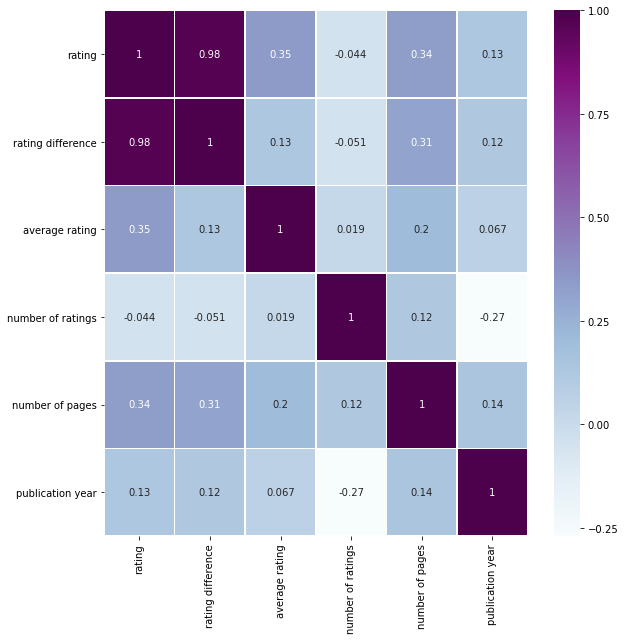

In [6]:
# get correlation matrix of my data
books_corr = books.corr()

# change figure size
fig, ax1 = plt.subplots(figsize=(9,9))

# create heat map of correlation matrix
sn.heatmap(books_corr, annot=True, linewidths=.5, cmap='BuPu')

# remove unnecessary output
plt.tight_layout()

* Strong positive correlation between "rating" and "rating difference" 
* Weak or almost no correlations everywhere else

## data visualization part I: comparing values and exploring the composition of my data

### distribution of my ratings

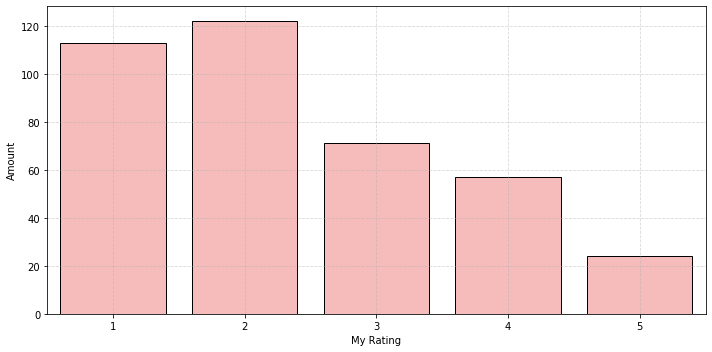

In [19]:
# Use SQL to group books by their given rating and counts the number of books in each rating
num_myratings = pd.read_sql('SELECT `rating`, COUNT(*) AS count FROM my_goodreads GROUP BY `rating`;', my_db)

# change figure size
plt.figure(figsize=(10,5))

# create the bar graph
sn.barplot(x='rating', y='count', data=num_myratings, color=(255/255, 179/255, 179/255, 1), edgecolor='black')

# add girdlines, rotate x-axis markers, and label the axes
plt.grid(alpha=.5, linestyle='--')
plt.xticks(rotation = 0)
plt.xlabel('My Rating')
plt.ylabel('Amount')

plt.tight_layout()

* 2-star ratings are the most common, while 5-star rating seem to be significantly common
* right-skewed: my ratings tend to fall on the lower end

#### distribution of my ratings by sex of author

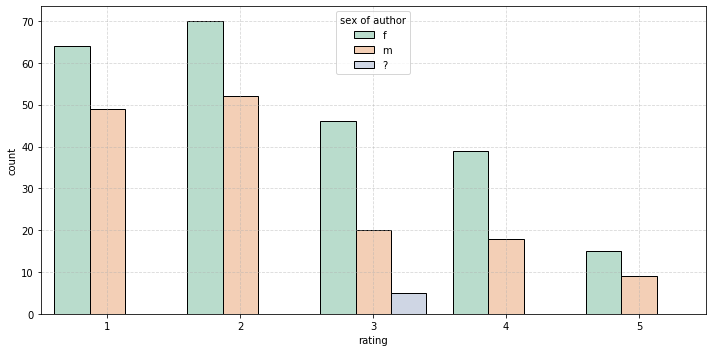

In [20]:
plt.figure(figsize=(10,5))
sn.countplot(x='rating', hue='sex of author', data=books, palette='Pastel2', edgecolor='black')
plt.grid(alpha=.5, linestyle='--')
plt.tight_layout()

* Female authors outnumber male authors for every star-rating

In [21]:
# calculate my average rating for female and male authors
avg_rating_by_sex = pd.read_sql('SELECT `sex of author`, AVG(`rating`) AS \'average rating\' FROM my_goodreads GROUP BY `sex of author`;', my_db)
avg_rating_by_sex

,sex of author,average rating
0,f,2.45
1,m,2.23
2,?,3.00


* The female authors I read have a slightly higher average than the male authors I read

### distribution of rating differences

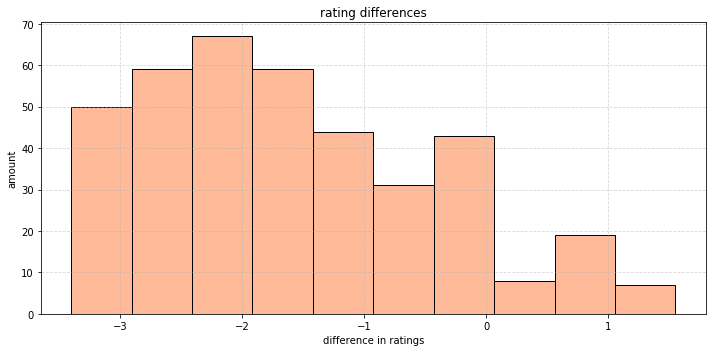

In [24]:
plt.figure(figsize=(10,5))
books['rating difference'].plot.hist(title='rating differences', color=(255/255, 187/255, 153/255,1), edgecolor='black')
plt.grid(alpha=0.5, linestyle='--')
plt.xlabel('difference in ratings')
plt.ylabel('amount')
plt.tight_layout()

* Right-skewed 
* Most books are rated lower than Goodreads' average rating
*  May be explained by:
    1. I might interpret each star-rating differently from a lot of Goodreads' users. For instance, some people give 3-star ratings to books they feel mediocre about, whereas I give a 1 or 2-star rating for a mediocre book
    2. I don't give out a lot of 4-star ratings and I rarely give out 5-star ratings, because they are reserved for absolute favourites
    3. I haven't read any books with an average rating below 3.16, so any book I give 3 or fewer stars to will count towards a negative difference

### distribution of Goodreads' average ratings

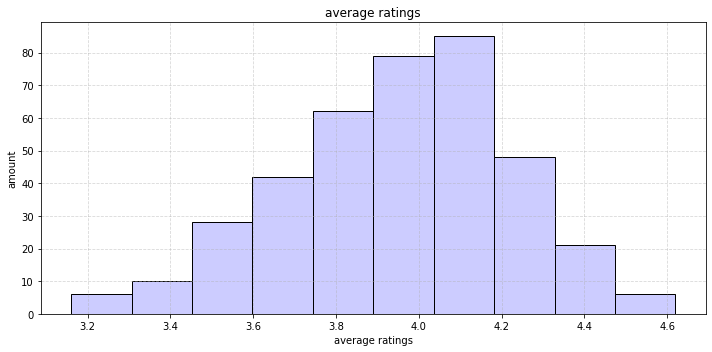

In [25]:
plt.figure(figsize=(10,5))
books['average rating'].plot.hist(title='average ratings', color=(204/255, 204/255, 255/255,1), edgecolor='black')
plt.grid(alpha=0.5, linestyle='--')
plt.xlabel('average ratings')
plt.ylabel('amount')
plt.tight_layout()

* Slightly left-skewed
* Most books I read have seem to have a good average rating on Goodreads

### distribution of the number of ratings

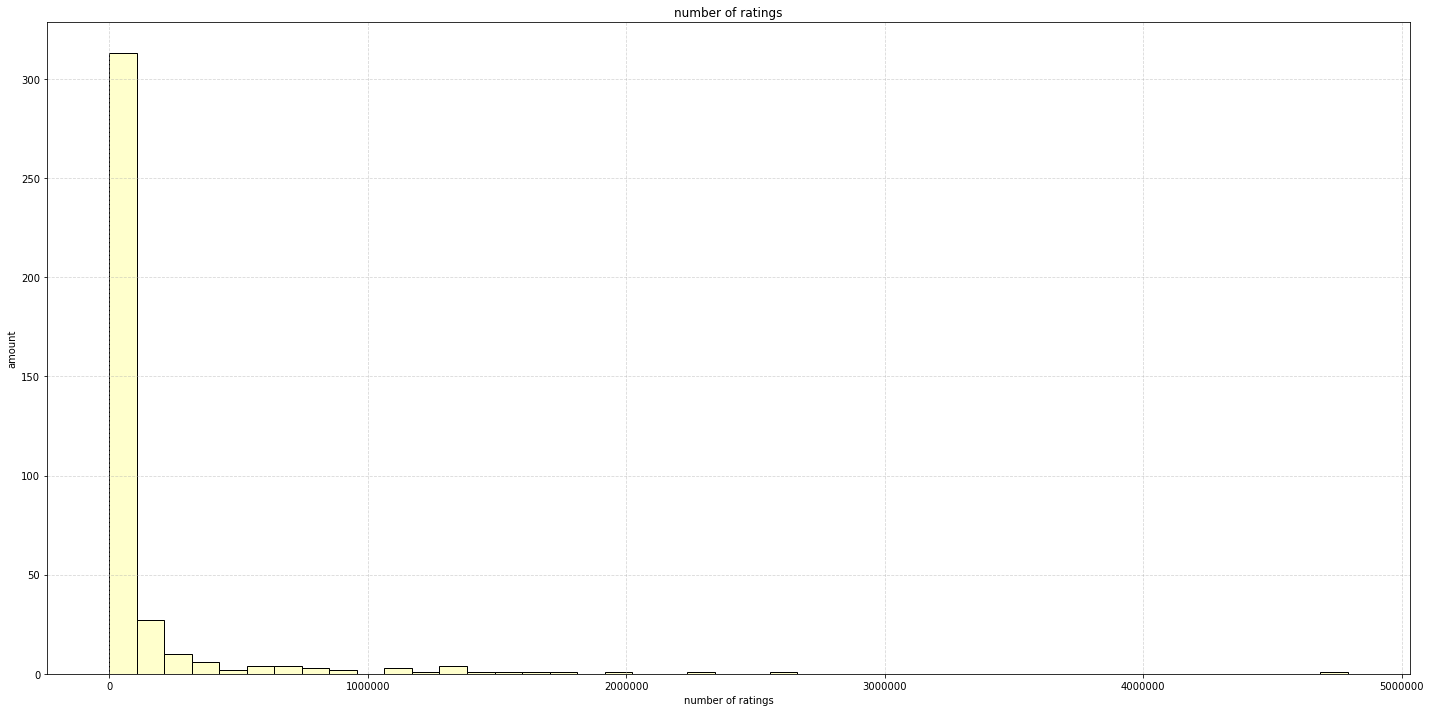

In [26]:
plt.figure(figsize=(20,10))
books['number of ratings'].plot.hist(bins=45, title='number of ratings', color=(255/255, 255/255, 204/255,1), edgecolor='black')
plt.grid(alpha=0.5, linestyle='--')
plt.xlabel('number of ratings')
plt.ylabel('amount')
plt.tight_layout()

* Distribution is heavily skewed right
* The vast majority of books I read have under ~111k ratings on Goodreads
* With so many published books out in the world, only a small percentage of them have or will hit mainstream status. Thus, it is more likely that the books I read have less than ~111k ratings on Goodreads. I also do not read books just because they are popular.

#### zoom in on books with under 111k ratings

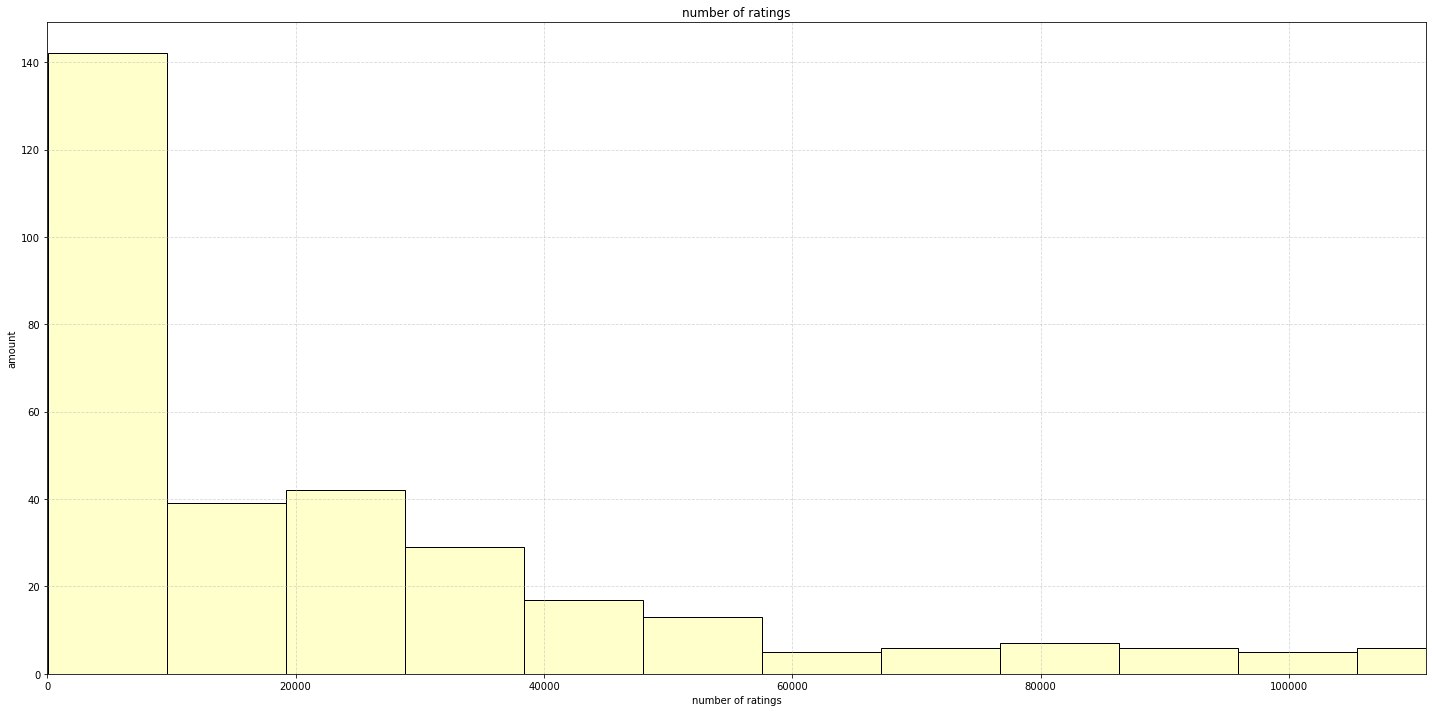

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(20, 10))
books['number of ratings'].plot.hist(bins=500,title='number of ratings', color=(255/255, 255/255, 204/255,1), edgecolor='black')
plt.grid(alpha=0.5, linestyle='--')
plt.xlabel('number of ratings')
plt.ylabel('amount')
ax.set_xlim([0, 111000])
plt.tight_layout()

* Distribution is still heavily skewed right

### distribution of pages

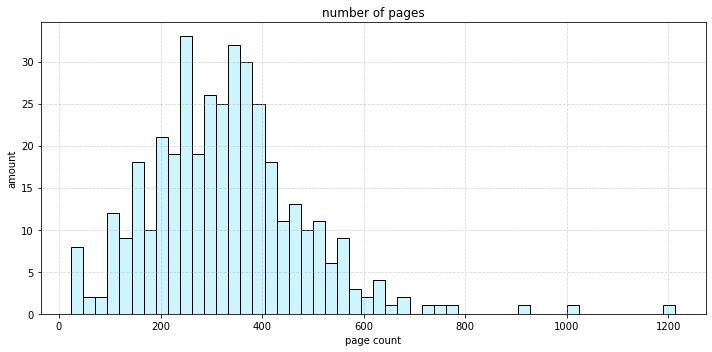

In [29]:
plt.figure(figsize=(10,5))
books['number of pages'].plot.hist(bins = 50, title='number of pages', color=(204/255, 245/255, 255/255,1), edgecolor='black')
plt.grid(alpha=0.5, linestyle='--')
plt.xlabel('page count')
plt.ylabel('amount')
plt.tight_layout()

* Distribution is slightly skewed right
* Distribution could be explained by 2 things:
1. My bias against very short (under 200 pages) and long books (over 500 pages). Long books requires more time, while very short books seem less capable of providing a fulfilling experience
2. Might also be the case that there are not as many short or long books compared to  books of moderate length (200-500 pages)

### distribution of publication years

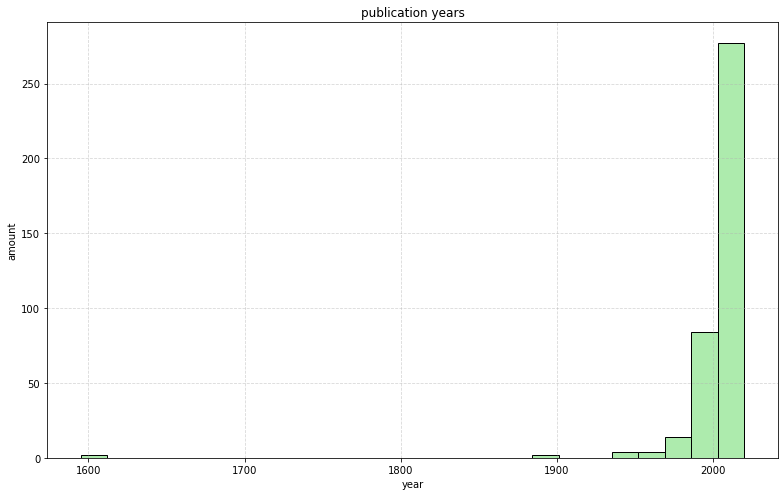

In [30]:
plt.figure(figsize=(11,7))
books['publication year'].plot.hist(bins=25,title='publication years', color=(173/255, 235/255, 173/255, 1), edgecolor='black') 
plt.grid(alpha=0.5, linestyle='--')
plt.xlabel('year')
plt.ylabel('amount')
plt.tight_layout()

* Distribution is heavily skewed left
* Majority of the books I read are published after 2000
* Distribution could be explained by 3 things:
1. I tend to not read classics
2. It might be harder to "discover" older, non-classic books, because they are forgotten or are less talked about
3. I find modern book covers to be more attractive than older ones, so it is more likely for a newer book to catch my attention

#### search for most common publication year

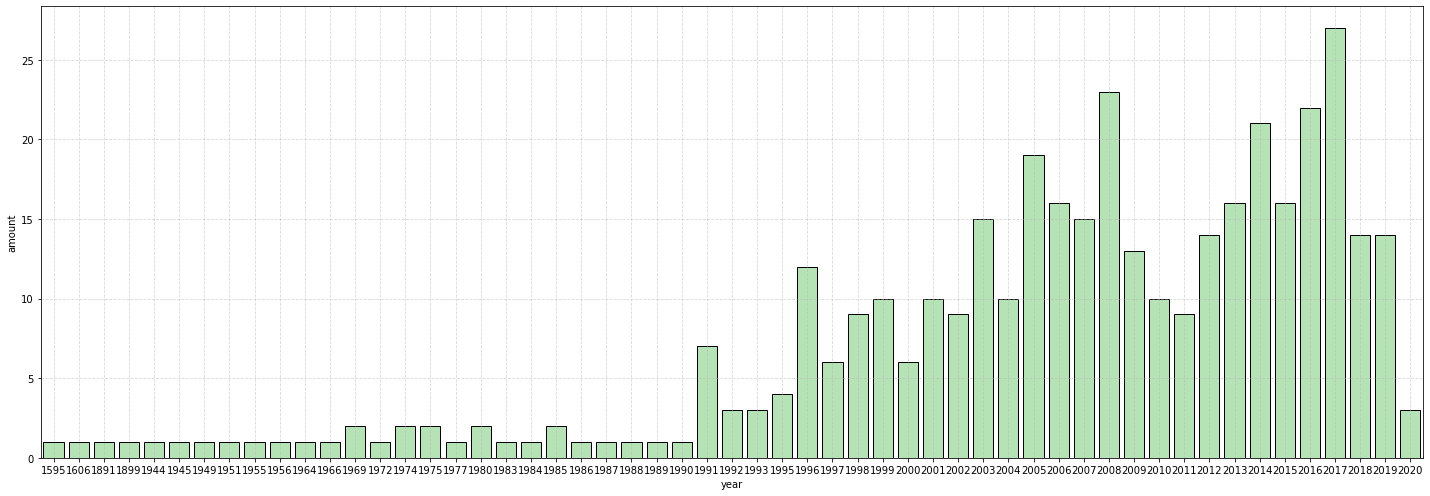

In [31]:
num_years = pd.read_sql('SELECT `publication year`, COUNT(*) as amount FROM my_goodreads GROUP BY `publication year`;', my_db)
plt.figure(figsize=(20,7)) 
sn.barplot(x='publication year', y='amount', data=num_years, color=(173/255, 235/255, 173/255, 1), edgecolor='black')
plt.grid(alpha=0.5, linestyle='--')
plt.xlabel('year')
plt.ylabel('amount')
plt.tight_layout()

* 2017 is the most common publication year for me, but does not seem to be in a significant way

### distribution of languages

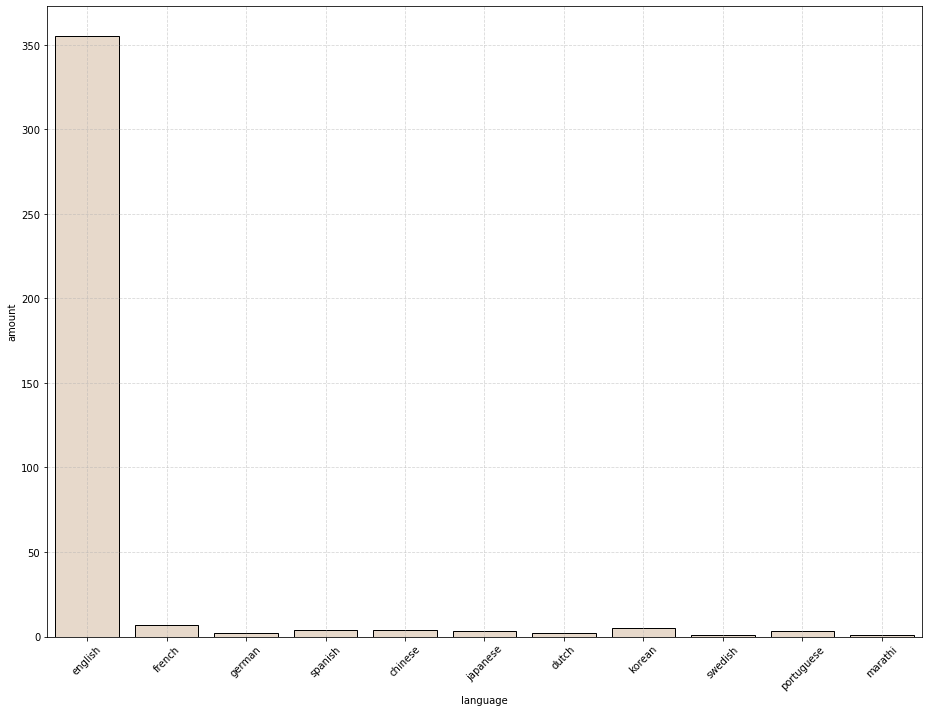

In [32]:
languages = pd.read_sql('SELECT `original language`, COUNT(*) as amount FROM my_goodreads GROUP BY `original language`;', my_db)
plt.figure(figsize=(13,10))
sn.barplot(x='original language', y='amount', data=languages, color=(236/255, 217/255, 198/255, 1), edgecolor='black')
plt.grid(alpha=0.5, linestyle='--')
plt.xticks(rotation = 45)
plt.xlabel('language')
plt.ylabel('amount')
plt.tight_layout()

* Vast majority of the books I've read were originally written in English
* Significant difference could be explained by:
1. Most non-English books are probably not translated into English
2. Some langauges do not translate well into English, so the writing style of the translation may deter me from reading it

### distribution of the sex of authors

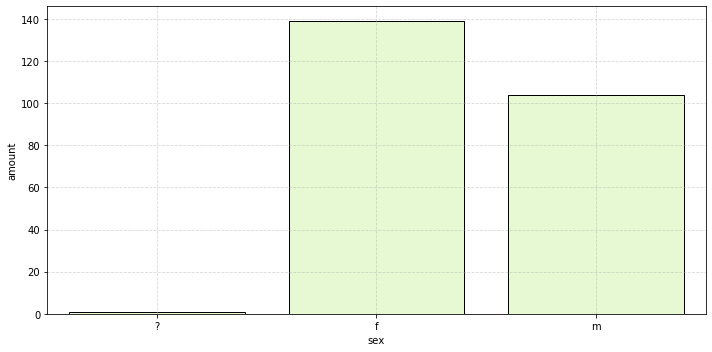

In [33]:
sexes = pd.read_sql('SELECT `sex of author`, COUNT(DISTINCT author) as amount FROM my_goodreads GROUP BY `sex of author`;', my_db)
plt.figure(figsize=(10,5))
sn.barplot(x='sex of author', y='amount', data=sexes, color=(230/255, 255/255, 204/255, 1), edgecolor='black')
plt.grid(alpha=0.5, linestyle='--')
plt.xticks(rotation = 0)
plt.xlabel('sex')
plt.ylabel('amount')
plt.tight_layout()

*  I have read more female authors than male authors, but difference does not appear significant
*  I do not take the sex of the author into account when it comes to books, so this observation is most likely the result of random chance

#### distribution of books by sex of author

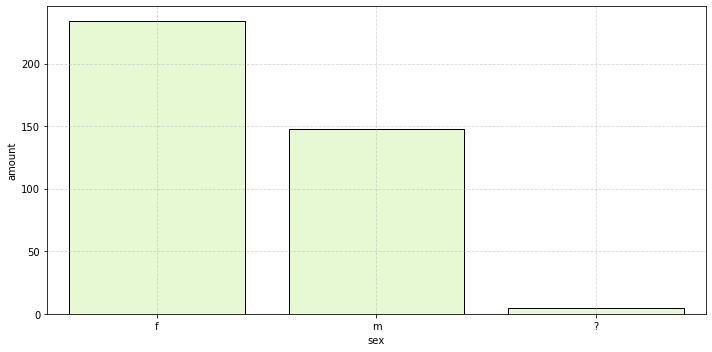

In [34]:
numbooks_bysex = pd.read_sql('SELECT `sex of author`, COUNT(*) as amount FROM my_goodreads GROUP BY `sex of author`;', my_db)
plt.figure(figsize=(10,5))
sn.barplot(x='sex of author', y='amount', data=numbooks_bysex, color=(230/255, 255/255, 204/255, 1), edgecolor='black')
plt.grid(alpha=0.5, linestyle='--')
plt.xticks(rotation = 0)
plt.xlabel('sex')
plt.ylabel('amount')
plt.tight_layout()

* I read more books by female authors than male authors
* An increase of ~100 for female authors and ~45 for male authors, so it seems that I have read more series by female authors
## data visualization part II: my ratings against other columns

### rating vs. average rating<a name='sub7'></a>

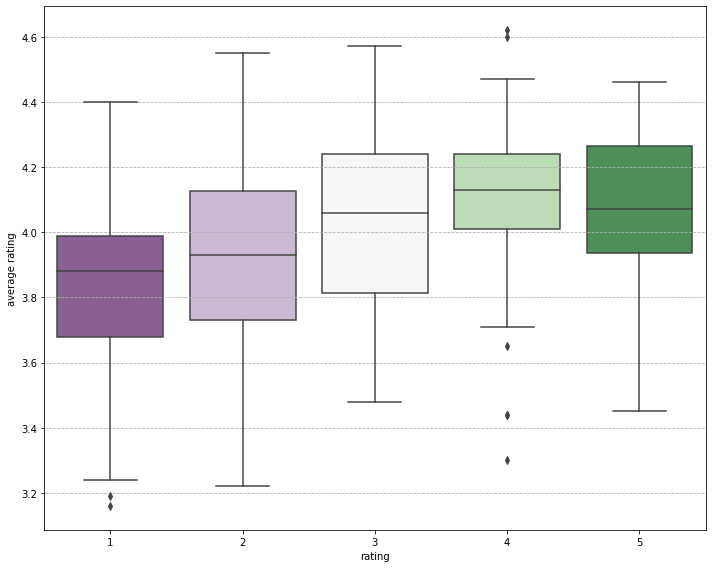

In [35]:
plt.figure(figsize=(10,8))

# create box plots
sn.boxplot(books['rating'], books['average rating'], palette='PRGn')

plt.grid(axis = 'y', linestyle='--')
plt.tight_layout()

* 5-star books aside: On average, the higher my rating, the higher the Goodreads' average rating. But, 5 star-books still tend to have higher average ratings than 1 and 2-star books
* 2-star books have the highest variety of average ratings, while 4-star books have the lowest variety of average ratings
* Many outliers for 4-star books

### rating vs. number of ratings<a name='sub8'></a>

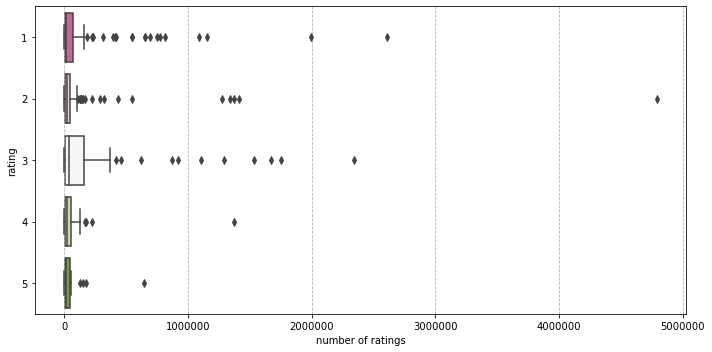

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10, 5))
sn.boxplot(books['number of ratings'], books['rating'], orient = 'h', palette='PiYG')

plt.grid(axis = 'x', linestyle='--')
plt.tight_layout()

* Many outliers that have more ratings than normal

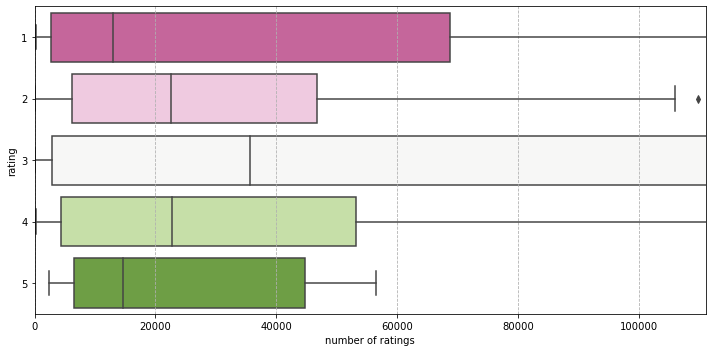

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10, 5))
sn.boxplot(books['number of ratings'], books['rating'], orient = 'h', palette='PiYG')

# set limit on x-axis, because vast majority of my read books have under 300k ratings
ax.set_xlim([0, 111000])

plt.grid(axis = 'x', linestyle='--')
plt.tight_layout()

* On average, my 3-star books have more ratings on Goodreads than any other rating
* Books I rated a 3 have the most variable fame on Goodreads, while books I rated a 5 have the least variable fame on Goodreads 
* For each star-rating, its distribution is skewed right

### rating vs. number of pages<a name='sub9'></a>

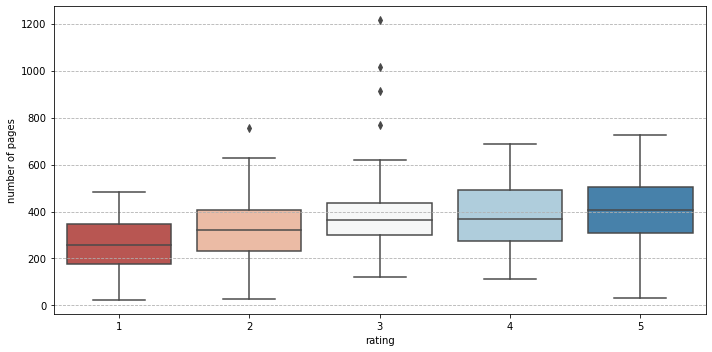

In [38]:
plt.figure(figsize=(10, 5))
sn.boxplot(books['rating'],books['number of pages'], palette='RdBu')
plt.grid(axis = 'y', linestyle='--')
plt.tight_layout()

* On average, my 3, 4, and 5-stars books are longer than my 1 and 2-star books. This makes sense, as I am less likely to finish long books I am not enjoying
* Variation in book length is small across all my ratings
* 3-star books have the most outliers

### rating vs. publication year

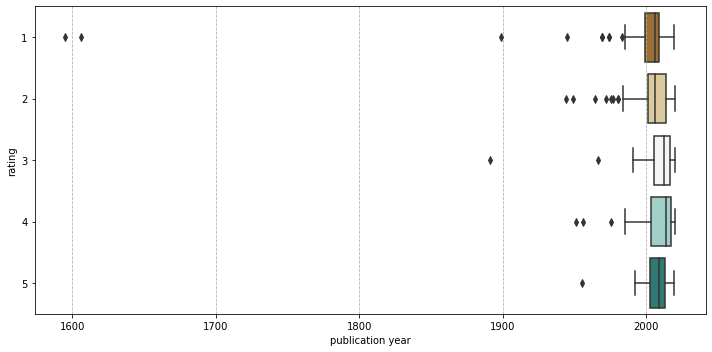

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10, 5))
sn.boxplot(books['publication year'],books['rating'], orient='h', palette='BrBG')
plt.grid(axis = 'x', linestyle='--')
plt.tight_layout()

* All outliers are older books

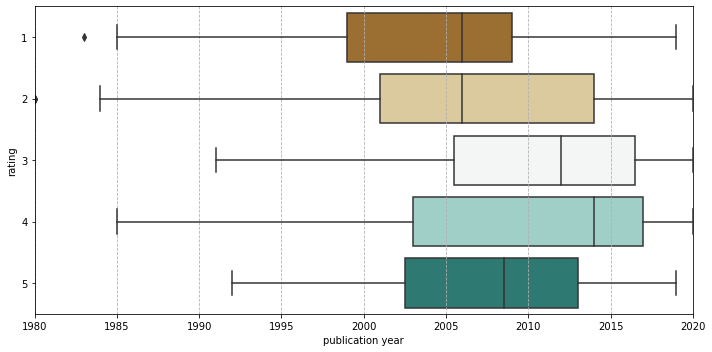

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10, 5))
sn.boxplot(books['publication year'],books['rating'], orient='h', palette='BrBG')

# set limit on x-axis, because vast majority of my read books is published after 1980 
ax.set_xlim([1980, 2020])

plt.grid(axis = 'x', linestyle='--')
plt.tight_layout()

* On average, my 4-star books are more recently published compared to the rest
* 2-star books have the highest variation in publication year

## conclusions

* From a numbers standpoint, I need to read more translated books and books published before the year 2000
* Goodreads' average ratings seem to be an okay indicator for my enjoyment of a book, but it should not deter me from reading a book that have intrigued me with its premise or writing style. For instance, most of the books I like (books rated 3 stars or more) have an average rating above 3.8, but there have been a good number of cases where I have liked a book rated below 3.8 